# Scaling ML workflows with Ray

We are going to scale three common machine learnign workloads:

1. Training
2. Hyperparameter tuning
3. Inference

First, we try on a local node with a data set, time it, and then try on a Ray cluster with multiple nodes and multiple cores.

We should observe noticiable difference.

<img src="https://images.ctfassets.net/xjan103pcp94/ETLioF3e6PLPYr5DggvUl/7f8247e1bf79ab49295882259bd5420d/localMachineCloud.png" width="40%" height="30%">

In [1]:
import ray
import numpy as np
import os
import pandas as pd
import glob

from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split

import time
import tqdm
import xgboost as xgb
import xgboost_ray
from xgboost.callback import TrainingCallback

## Read the data files into various chunks

Read the classifation data features and labes into 300MB, 3GB, and 11GB chunks to
illustrate training, tunning, and inferencing at scale.

The data is generated from `sklearn.datasets make_classification` with 2 classes as labels as default. More rows or classes can be easily generated. For this demo, we
will use the following: 

 * 10,000,000 rows
 * 40 feature columns
 * 2 classes

In [2]:

def get_parquet_files(path, size=10):
    """Get all parquet parts from a directory."""
    size *= 10
    files = sorted(glob.glob(path))
    while size > len(files):
        files = files + files
    files = files[0:size]
    return files

def load_parquet_dataset(files):
    """Load all parquet files into a pandas df."""
    df = pd.read_parquet(files[0])
    for i in tqdm.tqdm(range(1, len(files), 50)):
        df = pd.concat((df, pd.read_parquet(files[i:i+50])))
        memory_usage = df.memory_usage(deep=True).sum()/1e9
        tqdm.tqdm.write(f"Dataset size: {memory_usage} GB")
        if memory_usage > 12:
            raise MemoryError(f"Dataset too big to fit into memory!")
    return df[sorted(df.columns)].drop("partition", axis=1)

class TqdmCallback(TrainingCallback):
    """Simple callback to print a progress bar"""
    def __init__(self, num_samples: int) -> None:
        self.num_samples = num_samples
        super().__init__()

    def before_training(self, model):
        if xgb.rabit.get_rank() == 0:
            self.pbar = tqdm.tqdm(total=self.num_samples)
        return model

    def after_iteration(self, model, epoch, evals_log):
        if xgb.rabit.get_rank() == 0:
            self.pbar.update(1)

    def after_training(self, model):
        if xgb.rabit.get_rank() == 0:
            self.pbar.close()
        return model

data_path = f"/home/ec2-user/data/classification.parquet/**/*.parquet"

data_files_300MB = get_parquet_files(data_path, size=1)
data_files_3GB = get_parquet_files(data_path, size=10)
data_files_11GB = get_parquet_files(data_path, size=30)

# 1a. Training (regular XGBoost)

In [3]:
# XGBoost config.
xgboost_params = {
    "tree_method": "approx",
    "objective": "binary:logistic",
    "eval_metric": ["logloss", "error"],
}

from xgboost import DMatrix, train

def train_xgboost(config, files, progress_bar=True):
    start_time = time.time()

    target_column = "labels"

    # local loading of a parquet dataset
    # needs conversion to pandas as vanilla
    # xgboost can't work with parquet directly
    train_df = load_parquet_dataset(files[:int(len(files) * 0.75)])
    test_df = load_parquet_dataset(files[int(len(files) * 0.75):])
    train_x = train_df.drop(target_column, axis=1)
    train_y = train_df[target_column]
    test_x = test_df.drop(target_column, axis=1)
    test_y = test_df[target_column]

    train_set = DMatrix(train_x, train_y)
    test_set = DMatrix(test_x, test_y)

    evals_result = {}

    # Train the classifier
    bst = train(params=config,
                dtrain=train_set,
                evals=[(test_set, "eval")],
                evals_result=evals_result,
                verbose_eval=False,
                num_boost_round=10,
                callbacks=[TqdmCallback(10)] if progress_bar else [])
    print(f"Total time taken: {time.time()-start_time}")

    model_path = "model.xgb"
    bst.save_model(model_path)
    print("Final validation error: {:.4f}".format(
        evals_result["eval"]["error"][-1]))

    return bst

Try a smaller data set (300MB) to ensure the our xgboost trainer works

In [4]:
bst = train_xgboost(xgboost_params, data_files_300MB)

100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Dataset size: 0.23590022 GB


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


Dataset size: 0.101100124 GB


100%|██████████| 10/10 [00:14<00:00,  1.48s/it]

Total time taken: 18.434603214263916
Final validation error: 0.1478


Try a larger data set (3GB) to ensure the our xgboost trainer works

In [6]:
bst = train_xgboost(xgboost_params, data_files_3GB)

 50%|█████     | 1/2 [00:13<00:13, 13.10s/it]

Dataset size: 1.718702504 GB


100%|██████████| 2/2 [00:21<00:00, 10.71s/it]


Dataset size: 2.7896 GB


100%|██████████| 1/1 [00:06<00:00,  6.97s/it]


Dataset size: 0.842500748 GB


100%|██████████| 10/10 [03:41<00:00, 22.15s/it]


Total time taken: 254.95771074295044
Final validation error: 0.1472


# 1b. Training (XGBoost on Ray)

Requires only few lines of code changes to XGBoost to use distributed training on Ray:

 * `from xgboost_ray import RayDMatrix, train, RayParams`
 * Use `RayDMatrix` distributed [sharding and reading](https://github.com/ray-project/xgboost_ray#distributed-data-loading) to convert to XGBoost internal data structure
 * Add additional `RayParams` argument to `train_xgboost(...)` for level of parallelism
 
 This diagram depicts how Distributed XGBoost-Ray works on a Ray cluster
 
 <img src="images/xgboost_distributed.png" width="40%" height="30%">

In [5]:

ray.init()

{'node_ip_address': '10.0.0.231',
 'raylet_ip_address': '10.0.0.231',
 'redis_address': '10.0.0.231:6379',
 'object_store_address': '/tmp/ray/session_2022-02-22_15-40-13_223734_3835/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-02-22_15-40-13_223734_3835/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2022-02-22_15-40-13_223734_3835',
 'metrics_export_port': 61402,
 'node_id': '81867dbcb9d2d9d91dac18751a0fb027fab5e8c6f6f2045c372bdfc0'}

In [6]:
# XGBoost config.
xgboost_params = {
    "tree_method": "approx",
    "objective": "binary:logistic",
    "eval_metric": ["logloss", "error"],
}

from xgboost_ray import RayDMatrix, train, RayParams

def train_xgboost_ray(config, files, ray_params, progress_bar=True):
    start_time = time.time()

    target_column = "labels"
    ds = ray.data.read_parquet(files)

    split_index = int(ds.count() * (1 -0.3))
    X = ds.random_shuffle()
    X_train, X_valid = X.split_at_indices([split_index]) 

    ds_train = X_train.repartition(16)
    ds_valid = X_valid.repartition(16)
    train_set = RayDMatrix(ds_train, target_column, ignore=["partition"])
    test_set = RayDMatrix(ds_valid, target_column, ignore=["partition"])

    evals_result = {}

    # Train the classifier
    bst = train(params=config,
                dtrain=train_set,
                evals=[(test_set, "eval")],
                evals_result=evals_result,
                verbose_eval=False,
                num_boost_round=10,                       # equivalent to epochs or iterations
                callbacks=[TqdmCallback(10)] if progress_bar else [],
                ray_params=ray_params)                    # Ray parameters for parallelism
    print(f"Total time taken: {time.time()-start_time}")

    model_path = "model.xgb"
    bst.save_model(model_path)
    print("Final validation error: {:.4f}".format(
        evals_result["eval"]["error"][-1]))

    return bst

#### Make dataset available in cloud object storage
 * We uploaded the dataset in Cloud storage (S3) and changed the URL for each file in our 3 datasets. 

In [7]:
s3_data_files_300MB = [str(i).replace('/home/ec2-user/', 's3://anyscale-demo/') for i in data_files_300MB]
s3_data_files_3GB = [str(i).replace('/home/ec2-user/', 's3://anyscale-demo/') for i in data_files_3GB]
s3_data_files_11GB = [str(i).replace('/home/ec2-user/', 's3://anyscale-demo/') for i in data_files_11GB]

In [8]:
s3_data_files_300MB

['s3://anyscale-demo/data/classification.parquet/partition=0/part_0.parquet',
 's3://anyscale-demo/data/classification.parquet/partition=1/part_1.parquet',
 's3://anyscale-demo/data/classification.parquet/partition=10/part_10.parquet',
 's3://anyscale-demo/data/classification.parquet/partition=11/part_11.parquet',
 's3://anyscale-demo/data/classification.parquet/partition=12/part_12.parquet',
 's3://anyscale-demo/data/classification.parquet/partition=13/part_13.parquet',
 's3://anyscale-demo/data/classification.parquet/partition=14/part_14.parquet',
 's3://anyscale-demo/data/classification.parquet/partition=15/part_15.parquet',
 's3://anyscale-demo/data/classification.parquet/partition=16/part_16.parquet',
 's3://anyscale-demo/data/classification.parquet/partition=17/part_17.parquet']

#### Define RayParams for XGBoost level of parallelism
 * Eight actors, 
 * Each using 2-4 CPUs

In [9]:
remote_train_xgboost_ray = ray.remote(train_xgboost_ray)

In [10]:
bst = ray.get(remote_train_xgboost_ray.remote(xgboost_params, s3_data_files_300MB, RayParams(num_actors=4, cpus_per_actor=1)))

Repartition: 100%|██████████| 8/8 [00:00<00:00, 141.82it/s]
(train_xgboost_ray pid=3993) 2022-02-22 15:41:17,539	INFO main.py:983 -- [RayXGBoost] Created 4 new actors (4 total actors). Waiting until actors are ready for training.
(train_xgboost_ray pid=3993) 2022-02-22 15:41:19,938	INFO main.py:1028 -- [RayXGBoost] Starting XGBoost training.
(_RemoteRayXGBoostActor pid=3990) [15:41:19] task [xgboost.ray]:139832668022672 got new rank 2
(_RemoteRayXGBoostActor pid=3991) [15:41:19] task [xgboost.ray]:140191504756352 got new rank 1
(_RemoteRayXGBoostActor pid=4244) [15:41:19] task [xgboost.ray]:140567351439312 got new rank 0
(_RemoteRayXGBoostActor pid=4242) [15:41:19] task [xgboost.ray]:139718882975696 got new rank 3
100%|██████████| 10/10 [00:16<00:00,  1.67s/it]
(train_xgboost_ray pid=3993) 2022-02-22 15:41:37,256	INFO main.py:1507 -- [RayXGBoost] Finished XGBoost training on training data with total N=700,000 in 19.79 seconds (17.31 pure XGBoost training time).


(train_xgboost_ray pid=3993) Total time taken: 40.59337878227234
(train_xgboost_ray pid=3993) Final validation error: 0.1459


In [11]:
my_env = {
    "working_dir": ".",
    "pip": ["xgboost_ray", "tqdm", "fsspec", "s3fs", "pyarrow==4.0.1"]
}

In [12]:
ray.shutdown()
ray.init("anyscale://xgboost_demo", runtime_env=my_env, cluster_env="default_cluster_env_ml_1.9.2_py38")

Authenticating
Loaded Anyscale authentication token from ~/.anyscale/credentials.json.

Output
(anyscale +0.4s) .anyscale.yaml found in project_dir. Directory is attached to a project.
(anyscale +0.4s) Using project (name: phi-demos, project_dir: /home/ec2-user/working_dir, id: prj_26wrN4CCEw3fGhXMxzRAwvuk).
(anyscale +2.6s) cluster xgboost_demo exists but not running, this will restart cluster xgboost_demo.
(anyscale +7.3s) Starting cluster xgboost_demo with cluster_env=DEFAULT_APP_CONFIG_ID_ml_1.9.2_py38:1 and cluster_compute=connect-autogenerated-config-2022-02-21T02:43:29.870997. View at https://console.anyscale.com/projects/prj_26wrN4CCEw3fGhXMxzRAwvuk/clusters/ses_MKMq1wWB46nd1yUPjQmg27g9
(anyscale +8.3s) Waiting for cluster xgboost_demo to start. This may take a few minutes


2022-02-22 15:45:50,263	INFO packaging.py:352 -- Creating a file package for local directory '.'.
2022-02-22 15:45:50,278	INFO packaging.py:221 -- Pushing file package 'gcs://_ray_pkg_ca858bef2a99148c.zip' (1.58MiB) to Ray cluster...
2022-02-22 15:45:50,952	INFO packaging.py:224 -- Successfully pushed file package 'gcs://_ray_pkg_ca858bef2a99148c.zip'.


(anyscale +5m20.0s) Connected to xgboost_demo, see: https://console.anyscale.com/projects/prj_26wrN4CCEw3fGhXMxzRAwvuk/clusters/ses_MKMq1wWB46nd1yUPjQmg27g9
(anyscale +5m20.0s) URL for head node of cluster: https://session-mkmq1wwb46nd1yupjqmg27g9.i.anyscaleuserdata.com


AnyscaleClientContext(dashboard_url='https://session-mkmq1wwb46nd1yupjqmg27g9.i.anyscaleuserdata.com/auth/?token=105d3036-0168-445d-a8ec-f06e7a4ccaa2&redirect_to=dashboard', python_version='3.8.5', ray_version='1.9.2', ray_commit='ef593fe5d3c864836b80ae77be32635cef42b537', protocol_version='2021-09-22', _num_clients=1, _context_to_restore=None)

In [13]:

bst = ray.get(remote_train_xgboost_ray.remote(xgboost_params, s3_data_files_11GB, RayParams(num_actors=8, cpus_per_actor=4)))

Metadata Fetch Progress: 100%|██████████| 50/50 [00:27<00:00,  1.82it/s]


(pid=runtime_env, ip=10.0.0.127) 2022-02-22 07:53:55,689	INFO conda.py:295 -- Setting up conda environment with {'_ray_commit': 'ef593fe5d3c864836b80ae77be32635cef42b537', 'env_vars': {'RAY_SERVE_ROOT_URL': 'https://serve-session-mkmq1wwb46nd1yupjqmg27g9.i.anyscaleuserdata.com'}, 'pip': ['xgboost_ray', 'tqdm', 'fsspec', 's3fs', 'pyarrow==4.0.1'], 'working_dir': 'gcs://_ray_pkg_ca858bef2a99148c.zip'}
(pid=runtime_env, ip=10.0.0.118) 2022-02-22 07:53:55,673	INFO conda.py:295 -- Setting up conda environment with {'_ray_commit': 'ef593fe5d3c864836b80ae77be32635cef42b537', 'env_vars': {'RAY_SERVE_ROOT_URL': 'https://serve-session-mkmq1wwb46nd1yupjqmg27g9.i.anyscaleuserdata.com'}, 'pip': ['xgboost_ray', 'tqdm', 'fsspec', 's3fs', 'pyarrow==4.0.1'], 'working_dir': 'gcs://_ray_pkg_ca858bef2a99148c.zip'}
(pid=runtime_env, ip=10.0.0.204) 2022-02-22 07:53:55,726	INFO conda.py:295 -- Setting up conda environment with {'_ray_commit': 'ef593fe5d3c864836b80ae77be32635cef42b537', 'env_vars': {'RAY_SERV

Repartition: 100%|██████████| 8/8 [00:02<00:00,  2.91it/s]
(train_xgboost_ray pid=1064) 2022-02-22 07:57:01,814	INFO main.py:983 -- [RayXGBoost] Created 8 new actors (8 total actors). Waiting until actors are ready for training.
(_RemoteRayXGBoostActor pid=563, ip=10.0.0.118) [07:57:13] task [xgboost.ray]:139677186481024 got new rank 1
(_RemoteRayXGBoostActor pid=565, ip=10.0.0.118) [07:57:13] task [xgboost.ray]:140184285076112 got new rank 0
(train_xgboost_ray pid=1064) 2022-02-22 07:57:13,121	INFO main.py:1028 -- [RayXGBoost] Starting XGBoost training.
(train_xgboost_ray pid=1064) E0222 07:57:13.122759059    1064 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
(_RemoteRayXGBoostActor pid=3089) [07:57:13] task [xgboost.ray]:139874056604928 got new rank 7
(_RemoteRayXGBoostActor pid=433, ip=10.0.0.127) [07:57:13] task [xgboost.ray]:140028147842160 got new rank 3
(_RemoteRayXGBoostActor pid=1010, ip=10.0.0.127) [07:57:13] task [xgb

(train_xgboost_ray pid=1064) Total time taken: 504.5148375034332
(train_xgboost_ray pid=1064) Final validation error: 0.1474


# 2. Hyperparameter Tuning

[Ray Tune](https://docs.ray.io/en/latest/tune/index.html) will launch distributed HPO, using 8 remote actors, each with its own instance of the trainable func: `train_xgboost` defined above.

<img src="https://raw.githubusercontent.com/dmatrix/ray-core-tutorial/main/images/ray_tune_dist_hpo.png" width="40%" height="30%">

# Weight and Biases integration
We just added the WandB callback to log all of our experiment metrics into WandB in the tune.run callback.

In [ ]:
from ray import tune
import os
from ray.tune.integration.wandb import WandbLoggerCallback

project_name = f"XGBoost-Tune-Experiment-demo2"
api_key = "f542864df3b124b219a7c9e9a1d7a0404f02e9eb" # TODO: change this if you have your own API key
os.environ["TUNE_DISABLE_AUTO_CALLBACK_LOGGERS"] = "1"

# Set XGBoost config.
config = {
    "tree_method": "approx",
    "objective": "binary:logistic",
    "eval_metric": ["logloss", "error"],
    "eta": tune.loguniform(1e-4, 1e-1),
    "subsample": tune.uniform(0.5, 1.0),
    "max_depth": tune.randint(1, 9)
}

ray_params = RayParams(
    max_actor_restarts=1,
    gpus_per_actor=0,
    cpus_per_actor=4,
    num_actors=8)

my_sync_config = tune.SyncConfig(
    sync_on_checkpoint=False,
    upload_dir="s3://anyscale-demo/results/",
)

analysis = tune.run(
    tune.with_parameters(train_xgboost_ray, files=s3_data_files_300MB, ray_params=ray_params, progress_bar=False),
    # Use the `get_tune_resources` helper function to set the resources.
    resources_per_trial=ray_params.get_tune_resources(),
    config=config,
    num_samples=8,
    metric="eval-error",
    mode="min",
    #sync_config=my_sync_config,
    verbose=1,
    callbacks=[WandbLoggerCallback(
            project= project_name,
            api_key= api_key,
            log_config=True)]
    )

accuracy = 1. - analysis.best_result["eval-error"]
print(f"Best model parameters: {analysis.best_config}")
print(f"Best model total accuracy: {accuracy:.4f}")
print(analysis.best_config)

# 3b. Inference (XGBoost on Ray)


In [14]:
@ray.remote
def xgb_batch_inference(bst, files, RayParams):
    total_time = time.time()
    
    ds = ray.data.read_parquet(files)
    df_batch = ds.repartition(8)
    
    inference_df = RayDMatrix(df_batch, ignore=["labels", "partition"])
    results = xgboost_ray.predict(bst, inference_df, ray_params=RayParams )

    print(f"Total time taken: {time.time()-total_time}")
    return results

In [16]:
myRayParams = RayParams(num_actors=8)
batch_results = ray.get(xgb_batch_inference.remote(bst, s3_data_files_3GB, myRayParams))


Repartition: 100%|██████████| 8/8 [00:02<00:00,  3.41it/s]
(xgb_batch_inference pid=1996) 2022-02-22 08:02:11,007	INFO main.py:1547 -- [RayXGBoost] Created 8 remote actors.
(xgb_batch_inference pid=1996) 2022-02-22 08:02:18,725	INFO main.py:1564 -- [RayXGBoost] Starting XGBoost prediction.


(xgb_batch_inference pid=1996) Total time taken: 89.50701069831848


In [22]:
batch_results[:5]

array([0.66246784, 0.87776035, 0.83109486, 0.8470128 , 0.25731114],
      dtype=float32)

# 3c. Feature Importance (XGBoost on Ray)


In [19]:
@ray.remote
def xgb_feature_importance(bst, files, RayParams):
    total_time = time.time()
    
    ds = ray.data.read_parquet(files)
    df_batch = ds.repartition(8)
    
    inference_df = RayDMatrix(df_batch, ignore=["labels", "partition"])
    results = xgboost_ray.predict(bst, inference_df, ray_params=RayParams, pred_contribs=True )

    print(f"Total time taken: {time.time()-total_time}")
    return results

In [20]:
shap_values = ray.get(xgb_feature_importance.remote(bst, s3_data_files_300MB, myRayParams))

Repartition: 100%|██████████| 8/8 [00:00<00:00, 136.11it/s]
(xgb_feature_importance pid=2078) 2022-02-22 08:09:38,347	INFO main.py:1547 -- [RayXGBoost] Created 8 remote actors.
(xgb_feature_importance pid=2078) 2022-02-22 08:09:42,000	INFO main.py:1564 -- [RayXGBoost] Starting XGBoost prediction.


(xgb_feature_importance pid=2078) Total time taken: 71.72592973709106


In [21]:
print("SHAP Values Size : ", shap_values.shape)

print("\nSample SHAP Values : ",shap_values[0])
print("\nSumming SHAP Values for Prediction : ",shap_values.sum(axis=1)[:5]) # First 5 preds are only printed

SHAP Values Size :  (1000000, 41)

Sample SHAP Values :  [-1.4370294e-02 -1.7979965e-02  0.0000000e+00  0.0000000e+00
  1.0309145e-03  0.0000000e+00  0.0000000e+00  2.4133732e-03
 -1.6472527e-01  1.4171813e-01 -5.3994149e-02  0.0000000e+00
  0.0000000e+00  0.0000000e+00 -3.1148814e-02  0.0000000e+00
  5.3378278e-01  6.9158956e-02 -3.1400928e-03 -1.5454231e-01
  3.6187723e-01  0.0000000e+00 -1.6360761e-01 -2.0941973e-01
 -1.0361180e-02  0.0000000e+00  0.0000000e+00  3.1815204e-01
 -5.2554831e-03  4.0171068e-02  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00 -2.6863400e-02  0.0000000e+00
  1.1813082e-02  1.5001675e-02  4.0283035e-02 -6.1184368e-03
  4.3582215e-04]

Summing SHAP Values for Prediction :  [ 0.6743114   1.8231841   1.7259123  -0.23505044  1.5477774 ]


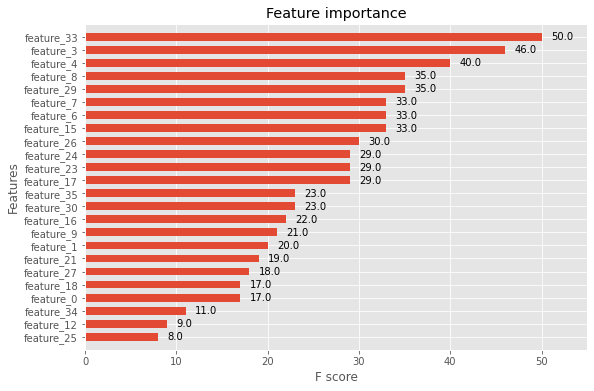

In [25]:
import matplotlib.pyplot as plt

with plt.style.context("ggplot"):
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111)
    xgb.plotting.plot_importance(bst, ax=ax, height=0.6, importance_type="weight")

---

# References
 * [Introducing Distributed XGBoost Training with Ray](https://www.anyscale.com/blog/distributed-xgboost-training-with-ray)
 * [How to Speed Up XGBoost Model Training](https://www.anyscale.com/blog/how-to-speed-up-xgboost-model-training)
 * [Distributed XGBoost on Ray](https://docs.ray.io/en/latest/xgboost-ray.html)

